En este notebook, se procesan y analizan los resultados obtenidos

In [1]:
import os
import pickle

from ast import literal_eval
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec, FastText
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


NUM_TOPICS=120
topics = range(0, NUM_TOPICS, 1)

TEXT_FILE_READ = 'docs/reddit_data_hate_speech.csv'
HATE_WORDS = 'docs/palabras_odio.csv'
TOPIC_TEST_FOLDER = 'docs/test/hstopic/'

os.makedirs(TOPIC_TEST_FOLDER, exist_ok=True)
np.random.seed(42)

In [2]:
reddit = pd.read_csv(TEXT_FILE_READ)
hate_words = pd.read_csv(HATE_WORDS)

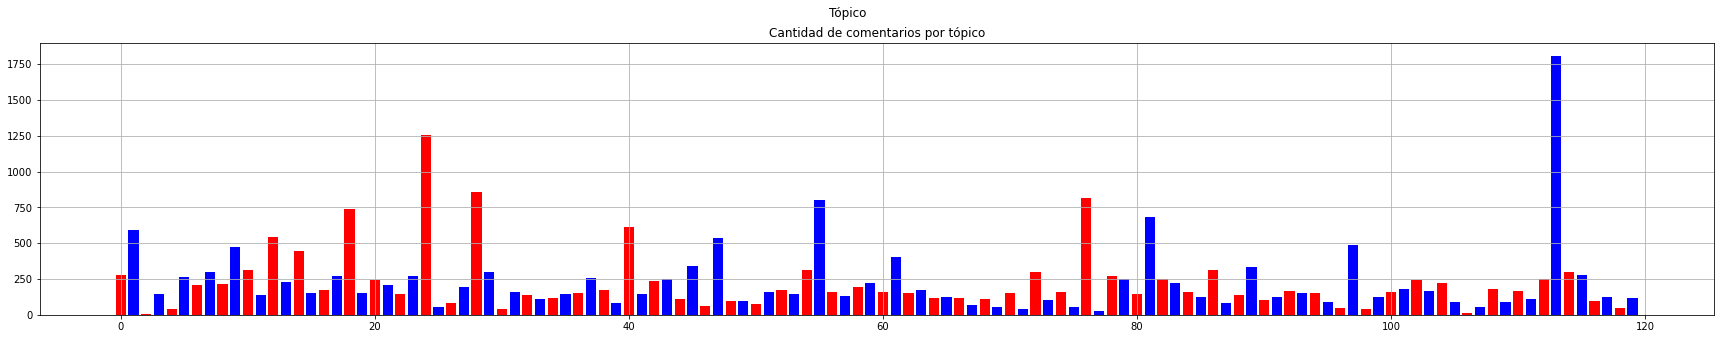

In [3]:
fig, (ax4) = plt.subplots(1, 1,figsize=(30,5))
fig.suptitle('Tópico ')

New_Colors = ['red','blue'] * int(NUM_TOPICS/2)

topics_range = range(0, NUM_TOPICS, 1)

topics_count = []

for i in range(NUM_TOPICS):
    temp = reddit.loc[(reddit["cluster"] == str([i]))]
    topics_count.append(len(temp))
    
ax4.bar(topics_range, topics_count, color=New_Colors)
ax4.set_title('Cantidad de comentarios por tópico')
ax4.grid(True)

In [4]:
def get_counts_words(reddit):
    words_hate_speech = []

    for sent in reddit['body_preprocessing']:
        for word in str(sent).split():
            words_hate_speech.append(word)
    return Counter(words_hate_speech)

In [5]:
def get_pmi_por_cluster(selected_cluster, hate_speech, minimum_word_occurrences=10):
    reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                      (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
    reddit_words_counter_hate = Counter(sum(list(reddit_words_hate),[]))
    
    word_pmis = {}

    total_msgs = len(reddit['body_preprocessing']) - reddit['body_preprocessing'].isnull().value_counts()[1]

    for word in reddit_words_counter_hate:
    
        try:
            p_non_hate_msg_without_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
            p_hate_msg_without_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
            p_non_hate_msg_with_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
            p_hate_msg_with_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
        except:
            continue

        if (p_non_hate_msg_with_word + p_hate_msg_with_word)*total_msgs >= minimum_word_occurrences:
            
            if hate_speech == "si":
                word_pmis[word] = np.log2(p_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
            elif hate_speech == "no":
                word_pmis[word] = np.log2(p_non_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
            else:
                raise ValueError("Se pasó un argumento desconocido para obtener pmi")

    return word_pmis

In [6]:
#type_analysis: el tipo de análisis hace referencia a como se analizan las palabras en cada cluster. 0 es por frecuencia; 1 es por información mutua.
def plot_word_cloud(topic_list, type_analysis='freq'):
    data = {'topic': [], 'score_hate_speech': [], 'score_not_hate_speech': [], 'comms_num_hate_speech': [], 'comms_num_not_hate_speech': []}
    df_marks = pd.DataFrame(data)
    
    for topic in topic_list:
        reddit_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "si")]
        reddit_not_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "no")]

        reddit_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_hp.csv')
        reddit_not_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_nhp.csv')

        types = ['Hate Speech','Not Hate Speech']
        score = [reddit_hate_speech['score'].mean(),reddit_not_hate_speech['score'].mean()]
        num_comments = [reddit_hate_speech['comms_num'].mean(),reddit_not_hate_speech['comms_num'].mean()]
        New_Colors = ['red','blue']

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(30,5))
        fig.suptitle('Tópico ' + str(topic))

        if len(reddit_hate_speech) > 0:
            if type_analysis == 'freq':
                ax1.imshow(WordCloud(random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                           .fit_words(get_counts_words(reddit_hate_speech)))
            elif type_analysis == 'pmi':
                ax1.imshow(WordCloud(random_state=1, max_words=20, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                       .fit_words(get_pmi_por_cluster(topic, "si")))
            else:
                raise ValueError('Se pasó una configuración de nube de palabras no definida')
                
        ax1.axis("off")
        ax1.set_title('Palabras Hate Speech')

        if len(reddit_not_hate_speech) > 0:
            if type_analysis == 'freq':
                ax2.imshow(WordCloud(random_state=1, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                       .fit_words(get_counts_words(reddit_not_hate_speech)))
            elif type_analysis == 'pmi':
                ax2.imshow(WordCloud(random_state=1, max_words=20, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                       .fit_words(get_pmi_por_cluster(topic, "no")))
            else:
                raise ValueError('Se pasó una configuración de nube de palabras no definida')
                
        ax2.axis("off")
        ax2.set_title('Palabras Not Hate Speech')

        ax3.bar(types, score, color=New_Colors)
        ax3.set_title('Puntaje promedio')
        ax3.grid(True)

        ax4.bar(types, num_comments, color=New_Colors)
        ax4.set_title('Números de comentarios promedio')
        ax4.grid(True)

        ax5.bar(types, [len(reddit_hate_speech), len(reddit_not_hate_speech)], color=New_Colors)
        ax5.set_title('Números de comentarios Clasificador por odio y no odio')
        ax5.grid(True)

        new_row = {'topic':topic, 'score_hate_speech':score[0], 'score_not_hate_speech':score[1], 'comms_num_hate_speech':num_comments[0], 'comms_num_not_hate_speech':num_comments[1]}
        df_marks = df_marks.append(new_row, ignore_index=True)
    
    return df_marks

In [7]:
def calcular_distancias(topic_list, model, kmeans):
    distances = {}
    
    for word in pd.Series([hate_words['hateval_rf'], hate_words['hateval_nb'],
                    hate_words['detoxis_rf'], hate_words['detoxis_nb'],
                    hate_words['meoffendmex_rf'], hate_words['meoffendmex_nb']]).iloc[0]:
        word_distance_per_topic = []
        for topic in topic_list:
            try:
                word_distance_per_topic.append(np.linalg.norm(model.wv.get_vector(word) - kmeans.cluster_centers_[topic]))
            except KeyError:
                word_distance_per_topic.append(np.inf)
        distances[word] = word_distance_per_topic
    
    return distances

In [8]:
def ver_palabras_asociadas(palabras_asociadas, embedding, clustering_model):
    for palabra_asociada in palabras_asociadas:
        print('Palabra: {}'.format(palabra_asociada))
        print('Clúster: {}'.format(clustering_model.predict(np.array([embedding.wv.get_vector(palabra_asociada)], dtype=float))))
        print('Términos cercanos: {} \n'.format(embedding.wv.most_similar(palabra_asociada)))

Los vemos en nube de palabras en base a las detecciones del modelo:

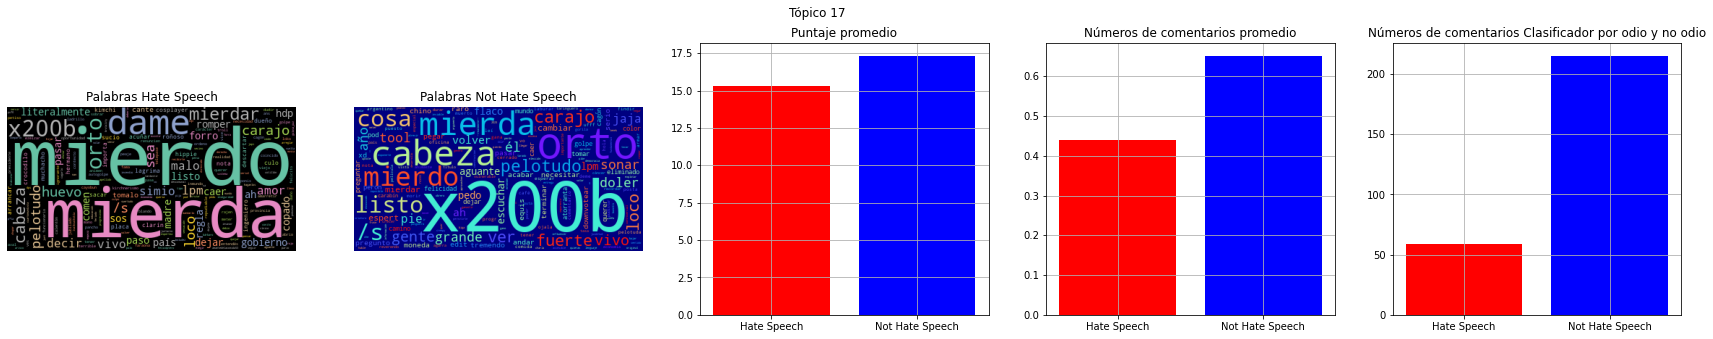

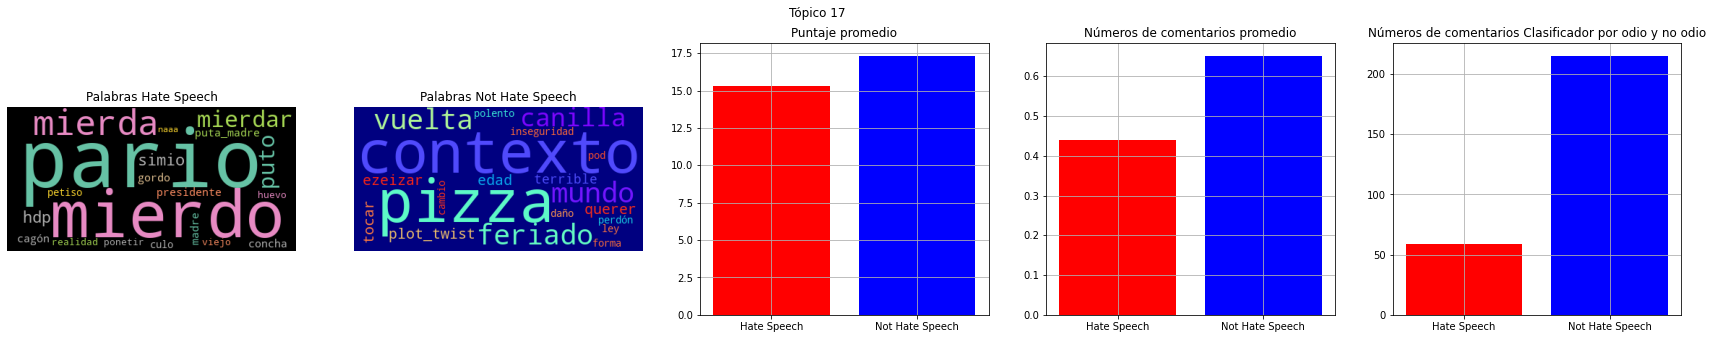

In [9]:
# algunos tópicos interesantes: [8, 13, 14, 18, 23, 44, 53, 59, 61, 64, 72, 73, 87, 94, 98, 99, 100, 104, 114]

df_marks = plot_word_cloud([17], "freq")
df_marks = plot_word_cloud([17], "pmi")

In [10]:
df_marks.describe()

,topic,score_hate_speech,score_not_hate_speech,comms_num_hate_speech,comms_num_not_hate_speech
count,1.0,1.000000,1.000000,1.000000,1.000000
mean,17.0,15.288136,17.311628,0.440678,0.651163
std,NaN,NaN,NaN,NaN,NaN
min,17.0,15.288136,17.311628,0.440678,0.651163
25%,17.0,15.288136,17.311628,0.440678,0.651163
50%,17.0,15.288136,17.311628,0.440678,0.651163
75%,17.0,15.288136,17.311628,0.440678,0.651163
max,17.0,15.288136,17.311628,0.440678,0.651163
